In [1]:
import pandas as pd

In [2]:
# posts_df
# Data columns (total 9 columns):
# #   Column            Dtype 
# ---  ------            -----
# 0   post_id           object
# 1   thread_id         object
# 2   user_id           int64
# 3   text              object
# 4   reposts_count     int64
# 5   likes_count       int64
# 6   comments_count    int64
# 7   parent_thread_id  object
# 8   timestamp         int64


# unique_users_df
# Data columns (total 7 columns):
# #   Column              Dtype 
# ---  ------              -----
# 0   user_id             int64
# 1   username            object
# 2   friends_count       int64
# 3   followers_count     int64
# 4   bi_followers_count  int64
# 5   user_created_at     int64
# 6   last_activity       int64 
users_df = pd.read_csv("../../dataset_zip/weibo_users_df.csv")

# labelled_posts_df
# Data columns (total 11 columns):
# #   Column            Non-Null Count  Dtype 
# ---  ------            --------------  -----
# 0   post_id           4718 non-null   object
# 1   label             4718 non-null   object
# 2   children          4718 non-null   object
# 3   thread_id         4718 non-null   object
# 4   user_id           4718 non-null   int64
# 5   text              4718 non-null   object
# 6   reposts_count     4718 non-null   int64
# 7   likes_count       4718 non-null   int64
# 8   comments_count    4718 non-null   int64
# 9   parent_thread_id  54 non-null     object
# 10  timestamp         4718 non-null   int64 
posts_df = pd.read_csv("../../dataset_zip/weibo_posts_merged_df.csv")


In [3]:
import re
import jieba

def clean_text(text):
    # Remove non-Chinese characters (keep Chinese, numbers, and basic punctuation)
    text = re.sub(r"[^\u4e00-\u9fffA-Za-z0-9,，.!?！？]", "", text)
    # Normalize spaces
    text = re.sub(r"\s+", " ", text).strip()
    return text

def segment_text(text):
    # Segment text using jieba
    words = jieba.lcut(text)
    # Join words back with spaces (useful for embeddings)
    return ' '.join(words)

# Load a list of Chinese stop words
with open('../../dataset_zip/cn_stopwords.txt', encoding='utf-8') as f:
    stopwords = set(f.read().splitlines())

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stopwords]
    return ' '.join(filtered_words)

In [4]:
posts_df['cleaned_text'] = posts_df['text'].fillna("").apply(clean_text)
posts_df['segmented_text'] = posts_df['cleaned_text'].apply(segment_text)
posts_df['final_text'] = posts_df['segmented_text'].apply(remove_stopwords)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache


Loading model cost 0.454 seconds.
Prefix dict has been built successfully.


In [5]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

# Prepare tagged documents
documents = [TaggedDocument(words=text.split(), tags=[i]) for i, text in enumerate(posts_df['final_text'])]
# Train the Doc2Vec model
model = Doc2Vec(documents, vector_size=100, window=5, min_count=2, workers=4)

# Add embeddings to the DataFrame
posts_df['text_embeddings'] = posts_df['final_text'].apply(lambda x: model.infer_vector(x.split()))


In [6]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Normalize engagement counts
scaler = MinMaxScaler()
posts_df[['reposts_count', 'likes_count', 'comments_count']] = scaler.fit_transform(
    posts_df[['reposts_count', 'likes_count', 'comments_count']]
)

# Extract time features
posts_df['hour'] = pd.to_datetime(posts_df['timestamp'], unit='s').dt.hour
posts_df['day'] = pd.to_datetime(posts_df['timestamp'], unit='s').dt.day
posts_df['month'] = pd.to_datetime(posts_df['timestamp'], unit='s').dt.month

In [7]:
users_df[['friends_count', 'followers_count', 'bi_followers_count']] = scaler.fit_transform(
    users_df[['friends_count', 'followers_count', 'bi_followers_count']]
)


In [8]:
merged_df = posts_df.merge(users_df, on='user_id', how='left')


In [11]:
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from model import CSIModel
import matplotlib.pyplot as plt

# Prepare data
X_text = np.stack(merged_df['text_embeddings'].values)
X_user = merged_df[['friends_count', 'followers_count', 'bi_followers_count']].values
y = (merged_df['label']).astype(int).values  # Convert labels to binary

# Custom Dataset class
class CSIDataset(Dataset):
    def __init__(self, text_data, user_data, labels):
        self.text_data = text_data
        self.user_data = user_data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = torch.tensor(self.text_data[idx], dtype=torch.float32)
        user = torch.tensor(self.user_data[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return text, user, label


# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Hyperparameters
text_embedding_dim = X_text.shape[1]
user_feature_dim = X_user.shape[1]
lstm_hidden_dim = 32
fc_hidden_dim = 16
learning_rate = 0.001
num_epochs = 50
k_folds = 5
batch_size = 32

# K-Fold Cross-Validation
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Loss function
criterion = nn.BCELoss()

# Store fold results
fold_results = []


for fold, (train_idx, val_idx) in enumerate(kf.split(X_text)):
    print(f"\nFold {fold + 1}/{k_folds}")

    # Split data into training and validation sets
    train_text = X_text[train_idx]
    train_user = X_user[train_idx]
    train_labels = y[train_idx]

    val_text = X_text[val_idx]
    val_user = X_user[val_idx]
    val_labels = y[val_idx]

    # Create DataLoaders for training and validation sets
    train_dataset = CSIDataset(train_text, train_user, train_labels)
    val_dataset = CSIDataset(val_text, val_user, val_labels)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize the model
    model = CSIModel(text_embedding_dim, user_feature_dim, lstm_hidden_dim, fc_hidden_dim)
    model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    # Training and Validation
    training_losses = []
    validation_losses = []
    for epoch in tqdm(range(1, num_epochs + 1), desc="Training Progress", unit="epoch"):
        model.train()
        total_train_loss = 0

        for text_batch, user_batch, labels_batch in train_loader:
            text_batch = text_batch.unsqueeze(1)
            text_batch, user_batch, labels_batch = (
                text_batch.to(device),
                user_batch.to(device),
                labels_batch.to(device),
            )

            optimizer.zero_grad()
            outputs = model(text_batch, user_batch).squeeze()
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        training_losses.append(avg_train_loss)

        # Validation
        model.eval()
        total_val_loss = 0
        val_labels_list = []
        val_preds_list = []
        with torch.no_grad():
            for text_batch, user_batch, labels_batch in val_loader:
                text_batch = text_batch.unsqueeze(1)
                text_batch, user_batch, labels_batch = (
                    text_batch.to(device),
                    user_batch.to(device),
                    labels_batch.to(device),
                )
                outputs = model(text_batch, user_batch).squeeze()
                loss = criterion(outputs, labels_batch)
                total_val_loss += loss.item()

                # Collect predictions and labels for metrics
                val_labels_list.extend(labels_batch.cpu().numpy())
                val_preds_list.extend((outputs > 0.5).cpu().numpy())

        avg_val_loss = total_val_loss / len(val_loader)
        validation_losses.append(avg_val_loss)

        # Print every 10 epochs
        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Calculate metrics for the fold
    precision = precision_score(val_labels_list, val_preds_list)
    recall = recall_score(val_labels_list, val_preds_list)
    f1 = f1_score(val_labels_list, val_preds_list)
    roc_auc = roc_auc_score(val_labels_list, val_preds_list)
    print(f"Fold {fold + 1} Metrics - Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, ROC AUC: {roc_auc:.4f}")
    fold_results.append((precision, recall, f1, roc_auc))


# Average results across folds
average_results = np.mean(fold_results, axis=0)
print("\nAverage Metrics Across All Folds")
print(f"Precision: {average_results[0]:.4f}, Recall: {average_results[1]:.4f}, F1: {average_results[2]:.4f}, ROC AUC: {average_results[3]:.4f}")



Fold 1/5


Training Progress:   0%|          | 0/50 [00:00<?, ?epoch/s]

Training Progress:  20%|██        | 10/50 [00:03<00:12,  3.15epoch/s]

Epoch 10/50 - Train Loss: 0.5832, Val Loss: 0.5655


Training Progress:  40%|████      | 20/50 [00:06<00:09,  3.15epoch/s]

Epoch 20/50 - Train Loss: 0.5149, Val Loss: 0.5009


Training Progress:  60%|██████    | 30/50 [00:09<00:06,  3.17epoch/s]

Epoch 30/50 - Train Loss: 0.4370, Val Loss: 0.4176


Training Progress:  80%|████████  | 40/50 [00:12<00:03,  3.15epoch/s]

Epoch 40/50 - Train Loss: 0.3810, Val Loss: 0.3659


Training Progress: 100%|██████████| 50/50 [00:15<00:00,  3.16epoch/s]


Epoch 50/50 - Train Loss: 0.3436, Val Loss: 0.3572
Fold 1 Metrics - Precision: 0.8110, Recall: 0.8957, F1: 0.8512, ROC AUC: 0.8487

Fold 2/5


Training Progress:  20%|██        | 10/50 [00:03<00:12,  3.15epoch/s]

Epoch 10/50 - Train Loss: 0.5778, Val Loss: 0.5789


Training Progress:  40%|████      | 20/50 [00:06<00:09,  3.13epoch/s]

Epoch 20/50 - Train Loss: 0.5169, Val Loss: 0.5152


Training Progress:  60%|██████    | 30/50 [00:09<00:06,  3.13epoch/s]

Epoch 30/50 - Train Loss: 0.4366, Val Loss: 0.4391


Training Progress:  80%|████████  | 40/50 [00:12<00:03,  3.09epoch/s]

Epoch 40/50 - Train Loss: 0.3834, Val Loss: 0.3667


Training Progress: 100%|██████████| 50/50 [00:15<00:00,  3.14epoch/s]


Epoch 50/50 - Train Loss: 0.3458, Val Loss: 0.3346
Fold 2 Metrics - Precision: 0.8066, Recall: 0.9219, F1: 0.8604, ROC AUC: 0.8611

Fold 3/5


Training Progress:  20%|██        | 10/50 [00:03<00:12,  3.16epoch/s]

Epoch 10/50 - Train Loss: 0.5793, Val Loss: 0.5946


Training Progress:  40%|████      | 20/50 [00:06<00:09,  3.16epoch/s]

Epoch 20/50 - Train Loss: 0.5270, Val Loss: 0.5771


Training Progress:  60%|██████    | 30/50 [00:09<00:06,  3.15epoch/s]

Epoch 30/50 - Train Loss: 0.4440, Val Loss: 0.4754


Training Progress:  80%|████████  | 40/50 [00:12<00:03,  3.15epoch/s]

Epoch 40/50 - Train Loss: 0.3910, Val Loss: 0.4145


Training Progress: 100%|██████████| 50/50 [00:15<00:00,  3.16epoch/s]


Epoch 50/50 - Train Loss: 0.3520, Val Loss: 0.3677
Fold 3 Metrics - Precision: 0.7860, Recall: 0.8879, F1: 0.8338, ROC AUC: 0.8315

Fold 4/5


Training Progress:  20%|██        | 10/50 [00:03<00:12,  3.15epoch/s]

Epoch 10/50 - Train Loss: 0.5920, Val Loss: 0.5608


Training Progress:  40%|████      | 20/50 [00:06<00:09,  3.15epoch/s]

Epoch 20/50 - Train Loss: 0.5307, Val Loss: 0.4958


Training Progress:  60%|██████    | 30/50 [00:09<00:06,  3.14epoch/s]

Epoch 30/50 - Train Loss: 0.4483, Val Loss: 0.4080


Training Progress:  80%|████████  | 40/50 [00:12<00:03,  3.14epoch/s]

Epoch 40/50 - Train Loss: 0.3864, Val Loss: 0.3524


Training Progress: 100%|██████████| 50/50 [00:15<00:00,  3.14epoch/s]


Epoch 50/50 - Train Loss: 0.3550, Val Loss: 0.3124
Fold 4 Metrics - Precision: 0.8658, Recall: 0.8640, F1: 0.8649, ROC AUC: 0.8632

Fold 5/5


Training Progress:  20%|██        | 10/50 [00:03<00:12,  3.16epoch/s]

Epoch 10/50 - Train Loss: 0.5637, Val Loss: 0.5725


Training Progress:  40%|████      | 20/50 [00:06<00:09,  3.16epoch/s]

Epoch 20/50 - Train Loss: 0.4982, Val Loss: 0.5064


Training Progress:  60%|██████    | 30/50 [00:09<00:06,  3.18epoch/s]

Epoch 30/50 - Train Loss: 0.4398, Val Loss: 0.4513


Training Progress:  80%|████████  | 40/50 [00:12<00:03,  3.16epoch/s]

Epoch 40/50 - Train Loss: 0.3931, Val Loss: 0.3696


Training Progress: 100%|██████████| 50/50 [00:15<00:00,  3.15epoch/s]

Epoch 50/50 - Train Loss: 0.3641, Val Loss: 0.3326
Fold 5 Metrics - Precision: 0.8539, Recall: 0.8792, F1: 0.8664, ROC AUC: 0.8642

Average Metrics Across All Folds
Precision: 0.8247, Recall: 0.8897, F1: 0.8554, ROC AUC: 0.8537


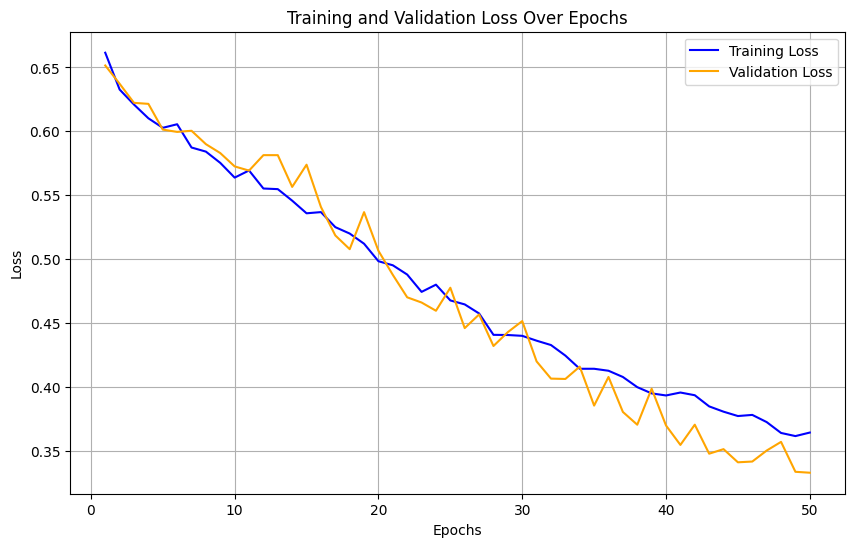

In [12]:
# Plot losses
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), training_losses, label='Training Loss', color='blue')
plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)

# Save the plot to a file
plt.savefig('training_validation_loss.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

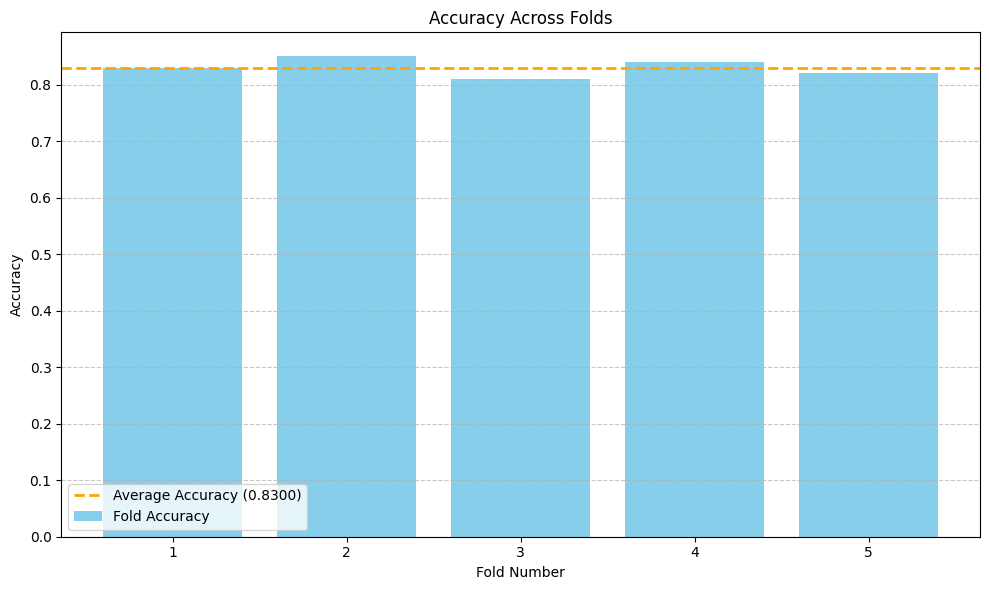

In [13]:
import matplotlib.pyplot as plt

# Example fold metrics
# Replace this with actual fold_metrics from your code
fold_metrics = [
    {"fold": 1, "accuracy": 0.83},
    {"fold": 2, "accuracy": 0.85},
    {"fold": 3, "accuracy": 0.81},
    {"fold": 4, "accuracy": 0.84},
    {"fold": 5, "accuracy": 0.82},
]

# Extract fold numbers and accuracy values
fold_numbers = [metric["fold"] for metric in fold_metrics]
accuracy_values = [metric["accuracy"] for metric in fold_metrics]
average_accuracy = sum(accuracy_values) / len(accuracy_values)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.bar(fold_numbers, accuracy_values, color="skyblue", label="Fold Accuracy")
plt.axhline(average_accuracy, color="orange", linestyle="--", linewidth=2, label=f"Average Accuracy ({average_accuracy:.4f})")

# Add labels and title
plt.xticks(fold_numbers)
plt.xlabel("Fold Number")
plt.ylabel("Accuracy")
plt.title("Accuracy Across Folds")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()


# DiceLoss

Applying PCA on Text Embeddings...


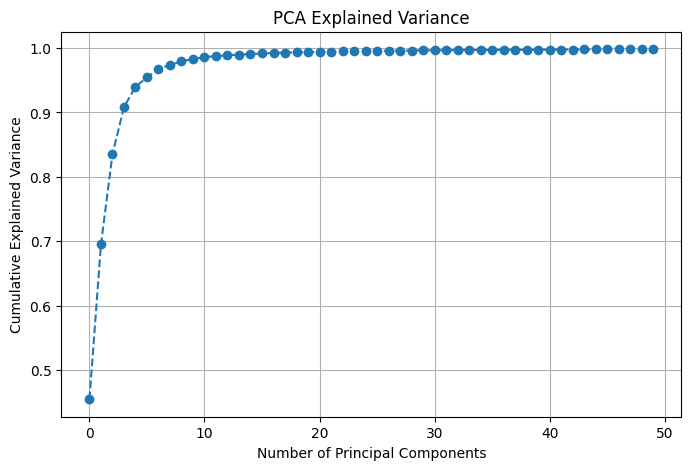


Fold 1/5


Training Progress:  10%|█         | 10/100 [00:03<00:29,  3.00epoch/s]

Epoch 10/100 - Train Loss: 0.4000, Val Loss: 0.5564


Training Progress:  20%|██        | 20/100 [00:06<00:26,  3.00epoch/s]

Epoch 20/100 - Train Loss: 0.3935, Val Loss: 0.5573


Training Progress:  30%|███       | 30/100 [00:09<00:23,  3.01epoch/s]

Epoch 30/100 - Train Loss: 0.3899, Val Loss: 0.5564


Training Progress:  40%|████      | 40/100 [00:13<00:19,  3.00epoch/s]

Epoch 40/100 - Train Loss: 0.3890, Val Loss: 0.5538


Training Progress:  50%|█████     | 50/100 [00:16<00:16,  3.01epoch/s]

Epoch 50/100 - Train Loss: 0.3839, Val Loss: 0.5533


Training Progress:  60%|██████    | 60/100 [00:19<00:13,  3.00epoch/s]

Epoch 60/100 - Train Loss: 0.3792, Val Loss: 0.5522


Training Progress:  70%|███████   | 70/100 [00:23<00:10,  2.99epoch/s]

Epoch 70/100 - Train Loss: 0.3782, Val Loss: 0.5508


Training Progress:  80%|████████  | 80/100 [00:26<00:06,  3.00epoch/s]

Epoch 80/100 - Train Loss: 0.3740, Val Loss: 0.5516


Training Progress:  90%|█████████ | 90/100 [00:29<00:03,  3.00epoch/s]

Epoch 90/100 - Train Loss: 0.3723, Val Loss: 0.5496


Training Progress: 100%|██████████| 100/100 [00:33<00:00,  3.00epoch/s]


Epoch 100/100 - Train Loss: 0.3729, Val Loss: 0.5497
Fold 1 Metrics - Accuracy: 0.8231, Precision: 0.7436, Recall: 0.9624, F1: 0.8390, ROC AUC: 0.8288

Fold 2/5


Training Progress:  10%|█         | 10/100 [00:03<00:30,  3.00epoch/s]

Epoch 10/100 - Train Loss: 0.4070, Val Loss: 0.5215


Training Progress:  20%|██        | 20/100 [00:06<00:26,  3.00epoch/s]

Epoch 20/100 - Train Loss: 0.4028, Val Loss: 0.5218


Training Progress:  30%|███       | 30/100 [00:09<00:23,  3.00epoch/s]

Epoch 30/100 - Train Loss: 0.4003, Val Loss: 0.5216


Training Progress:  40%|████      | 40/100 [00:13<00:20,  3.00epoch/s]

Epoch 40/100 - Train Loss: 0.3953, Val Loss: 0.5213


Training Progress:  50%|█████     | 50/100 [00:16<00:16,  3.00epoch/s]

Epoch 50/100 - Train Loss: 0.3920, Val Loss: 0.5191


Training Progress:  60%|██████    | 60/100 [00:19<00:13,  3.00epoch/s]

Epoch 60/100 - Train Loss: 0.3884, Val Loss: 0.5189


Training Progress:  70%|███████   | 70/100 [00:23<00:09,  3.01epoch/s]

Epoch 70/100 - Train Loss: 0.3859, Val Loss: 0.5187


Training Progress:  80%|████████  | 80/100 [00:26<00:06,  3.01epoch/s]

Epoch 80/100 - Train Loss: 0.3834, Val Loss: 0.5155


Training Progress:  90%|█████████ | 90/100 [00:29<00:03,  3.00epoch/s]

Epoch 90/100 - Train Loss: 0.3810, Val Loss: 0.5143


Training Progress: 100%|██████████| 100/100 [00:33<00:00,  3.00epoch/s]


Epoch 100/100 - Train Loss: 0.3790, Val Loss: 0.5145
Fold 2 Metrics - Accuracy: 0.8475, Precision: 0.7963, Recall: 0.9559, F1: 0.8689, ROC AUC: 0.8409

Fold 3/5


Training Progress:  10%|█         | 10/100 [00:03<00:29,  3.00epoch/s]

Epoch 10/100 - Train Loss: 0.4003, Val Loss: 0.5577


Training Progress:  20%|██        | 20/100 [00:06<00:26,  3.01epoch/s]

Epoch 20/100 - Train Loss: 0.3967, Val Loss: 0.5596


Training Progress:  30%|███       | 30/100 [00:09<00:23,  3.01epoch/s]

Epoch 30/100 - Train Loss: 0.3906, Val Loss: 0.5590


Training Progress:  40%|████      | 40/100 [00:13<00:19,  3.00epoch/s]

Epoch 40/100 - Train Loss: 0.3886, Val Loss: 0.5556


Training Progress:  50%|█████     | 50/100 [00:16<00:16,  3.01epoch/s]

Epoch 50/100 - Train Loss: 0.3825, Val Loss: 0.5535


Training Progress:  60%|██████    | 60/100 [00:19<00:13,  3.01epoch/s]

Epoch 60/100 - Train Loss: 0.3801, Val Loss: 0.5518


Training Progress:  70%|███████   | 70/100 [00:23<00:09,  3.01epoch/s]

Epoch 70/100 - Train Loss: 0.3774, Val Loss: 0.5518


Training Progress:  80%|████████  | 80/100 [00:26<00:06,  3.01epoch/s]

Epoch 80/100 - Train Loss: 0.3735, Val Loss: 0.5497


Training Progress:  90%|█████████ | 90/100 [00:29<00:03,  3.00epoch/s]

Epoch 90/100 - Train Loss: 0.3741, Val Loss: 0.5482


Training Progress: 100%|██████████| 100/100 [00:33<00:00,  3.01epoch/s]


Epoch 100/100 - Train Loss: 0.3727, Val Loss: 0.5485
Fold 3 Metrics - Accuracy: 0.8284, Precision: 0.7483, Recall: 0.9715, F1: 0.8454, ROC AUC: 0.8331

Fold 4/5


Training Progress:  10%|█         | 10/100 [00:03<00:29,  3.02epoch/s]

Epoch 10/100 - Train Loss: 0.3961, Val Loss: 0.5673


Training Progress:  20%|██        | 20/100 [00:06<00:26,  3.03epoch/s]

Epoch 20/100 - Train Loss: 0.3924, Val Loss: 0.5661


Training Progress:  30%|███       | 30/100 [00:09<00:23,  3.03epoch/s]

Epoch 30/100 - Train Loss: 0.3892, Val Loss: 0.5670


Training Progress:  40%|████      | 40/100 [00:13<00:19,  3.03epoch/s]

Epoch 40/100 - Train Loss: 0.3846, Val Loss: 0.5663


Training Progress:  50%|█████     | 50/100 [00:16<00:16,  3.02epoch/s]

Epoch 50/100 - Train Loss: 0.3820, Val Loss: 0.5646


Training Progress:  60%|██████    | 60/100 [00:19<00:13,  3.03epoch/s]

Epoch 60/100 - Train Loss: 0.3792, Val Loss: 0.5649


Training Progress:  70%|███████   | 70/100 [00:23<00:09,  3.03epoch/s]

Epoch 70/100 - Train Loss: 0.3748, Val Loss: 0.5638


Training Progress:  80%|████████  | 80/100 [00:26<00:06,  3.03epoch/s]

Epoch 80/100 - Train Loss: 0.3734, Val Loss: 0.5629


Training Progress:  90%|█████████ | 90/100 [00:29<00:03,  3.03epoch/s]

Epoch 90/100 - Train Loss: 0.3716, Val Loss: 0.5616


Training Progress: 100%|██████████| 100/100 [00:33<00:00,  3.03epoch/s]


Epoch 100/100 - Train Loss: 0.3691, Val Loss: 0.5621
Fold 4 Metrics - Accuracy: 0.8335, Precision: 0.7509, Recall: 0.9563, F1: 0.8413, ROC AUC: 0.8423

Fold 5/5


Training Progress:  10%|█         | 10/100 [00:03<00:29,  3.03epoch/s]

Epoch 10/100 - Train Loss: 0.4020, Val Loss: 0.5455


Training Progress:  20%|██        | 20/100 [00:06<00:26,  3.03epoch/s]

Epoch 20/100 - Train Loss: 0.3984, Val Loss: 0.5459


Training Progress:  30%|███       | 30/100 [00:09<00:23,  3.03epoch/s]

Epoch 30/100 - Train Loss: 0.3929, Val Loss: 0.5389


Training Progress:  40%|████      | 40/100 [00:13<00:19,  3.03epoch/s]

Epoch 40/100 - Train Loss: 0.3894, Val Loss: 0.5399


Training Progress:  50%|█████     | 50/100 [00:16<00:16,  3.02epoch/s]

Epoch 50/100 - Train Loss: 0.3841, Val Loss: 0.5376


Training Progress:  60%|██████    | 60/100 [00:19<00:13,  3.03epoch/s]

Epoch 60/100 - Train Loss: 0.3823, Val Loss: 0.5405


Training Progress:  70%|███████   | 70/100 [00:23<00:09,  3.03epoch/s]

Epoch 70/100 - Train Loss: 0.3791, Val Loss: 0.5359


Training Progress:  80%|████████  | 80/100 [00:26<00:06,  3.03epoch/s]

Epoch 80/100 - Train Loss: 0.3778, Val Loss: 0.5362


Training Progress:  90%|█████████ | 90/100 [00:29<00:03,  3.03epoch/s]

Epoch 90/100 - Train Loss: 0.3759, Val Loss: 0.5344


Training Progress: 100%|██████████| 100/100 [00:33<00:00,  3.03epoch/s]

Epoch 100/100 - Train Loss: 0.3749, Val Loss: 0.5347
Fold 5 Metrics - Accuracy: 0.8367, Precision: 0.7757, Recall: 0.9469, F1: 0.8528, ROC AUC: 0.8368

Average Metrics Across All Folds
Accuracy: 0.8338
Precision: 0.7630
Recall: 0.9586
F1: 0.8495
Roc_auc: 0.8364


In [13]:
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from model import CSIModel
import matplotlib.pyplot as plt

# Prepare data
X_text = np.stack(merged_df['text_embeddings'].values)
X_user = merged_df[['friends_count', 'followers_count', 'bi_followers_count']].values
y = (merged_df['label']).astype(int).values  # Convert labels to binary

# Apply PCA to reduce dimensions of text embeddings
print("Applying PCA on Text Embeddings...")
pca = PCA(n_components=50)  # Choose the number of components
X_text_pca = pca.fit_transform(X_text)

# Visualize explained variance ratio
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid()
plt.show()

# Custom Dataset class
class CSIDataset(Dataset):
    def __init__(self, text_data, user_data, labels):
        self.text_data = text_data
        self.user_data = user_data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = torch.tensor(self.text_data[idx], dtype=torch.float32)
        user = torch.tensor(self.user_data[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return text, user, label

class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)
        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        return dice_loss

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
text_embedding_dim = X_text_pca.shape[1]  # Updated to the PCA output dimensions
user_feature_dim = X_user.shape[1]
lstm_hidden_dim = 32
fc_hidden_dim = 16
learning_rate = 0.001
num_epochs = 100
k_folds = 5
batch_size = 32

# K-Fold Cross-Validation
kf = KFold(n_splits=k_folds, shuffle=True, random_state=32)

# Loss function
criterion = DiceLoss()

# Store fold results
fold_results = []
fold_metrics = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_text_pca)):
    print(f"\nFold {fold + 1}/{k_folds}")

    # Split data into training and validation sets
    train_text = X_text_pca[train_idx]
    train_user = X_user[train_idx]
    train_labels = y[train_idx]

    val_text = X_text_pca[val_idx]
    val_user = X_user[val_idx]
    val_labels = y[val_idx]

    # Create DataLoaders for training and validation sets
    train_dataset = CSIDataset(train_text, train_user, train_labels)
    val_dataset = CSIDataset(val_text, val_user, val_labels)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize the model
    model = CSIModel(text_embedding_dim, user_feature_dim, lstm_hidden_dim, fc_hidden_dim)
    model.to(device)

    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    # Training and Validation
    training_losses = []
    validation_losses = []
    for epoch in tqdm(range(1, num_epochs + 1), desc="Training Progress", unit="epoch"):
        model.train()
        total_train_loss = 0

        for text_batch, user_batch, labels_batch in train_loader:
            text_batch = text_batch.unsqueeze(1)
            text_batch, user_batch, labels_batch = (
                text_batch.to(device),
                user_batch.to(device),
                labels_batch.to(device),
            )

            optimizer.zero_grad()
            outputs = model(text_batch, user_batch).squeeze()
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        training_losses.append(avg_train_loss)

        # Validation
        model.eval()
        total_val_loss = 0
        val_labels_list = []
        val_preds_list = []
        with torch.no_grad():
            for text_batch, user_batch, labels_batch in val_loader:
                text_batch = text_batch.unsqueeze(1)
                text_batch, user_batch, labels_batch = (
                    text_batch.to(device),
                    user_batch.to(device),
                    labels_batch.to(device),
                )
                outputs = model(text_batch, user_batch).squeeze()
                loss = criterion(outputs, labels_batch)
                total_val_loss += loss.item()

                # Collect predictions and labels for metrics
                val_labels_list.extend(labels_batch.cpu().numpy())
                val_preds_list.extend((outputs > 0.5).cpu().numpy())

        avg_val_loss = total_val_loss / len(val_loader)
        validation_losses.append(avg_val_loss)

        # Print every 10 epochs
        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Calculate metrics for the fold
    accuracy = accuracy_score(val_labels_list, val_preds_list)
    precision = precision_score(val_labels_list, val_preds_list)
    recall = recall_score(val_labels_list, val_preds_list)
    f1 = f1_score(val_labels_list, val_preds_list)
    roc_auc = roc_auc_score(val_labels_list, val_preds_list)
    print(f"Fold {fold + 1} Metrics - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, ROC AUC: {roc_auc:.4f}")

    # Store fold metrics
    fold_metrics.append({
        "fold": fold + 1,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc,
    })

# Average results across folds
average_metrics = {
    key: np.mean([fold[key] for fold in fold_metrics])
    for key in fold_metrics[0] if key != "fold"
}
print("\nAverage Metrics Across All Folds")
for metric, value in average_metrics.items():
    print(f"{metric.capitalize()}: {value:.4f}")

# PCA


Applying PCA on Text Embeddings...


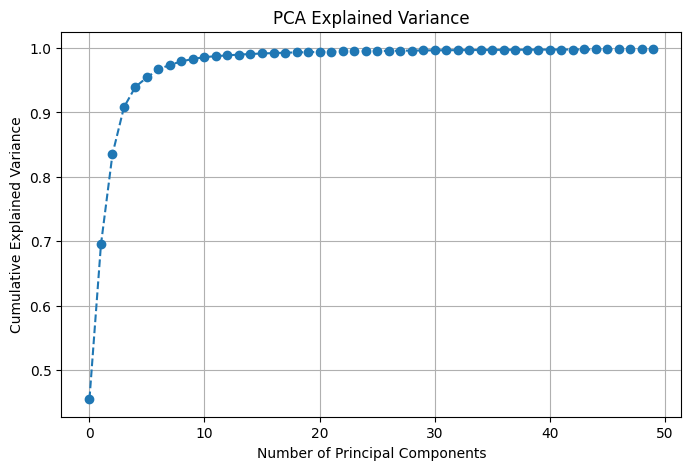


Fold 1/5


Training Progress:  10%|█         | 10/100 [00:03<00:27,  3.23epoch/s]

Epoch 10/100 - Train Loss: 0.5548, Val Loss: 0.5341


Training Progress:  20%|██        | 20/100 [00:06<00:24,  3.23epoch/s]

Epoch 20/100 - Train Loss: 0.4906, Val Loss: 0.4623


Training Progress:  30%|███       | 30/100 [00:09<00:21,  3.23epoch/s]

Epoch 30/100 - Train Loss: 0.4222, Val Loss: 0.4022


Training Progress:  40%|████      | 40/100 [00:12<00:18,  3.23epoch/s]

Epoch 40/100 - Train Loss: 0.3852, Val Loss: 0.3607


Training Progress:  50%|█████     | 50/100 [00:15<00:15,  3.23epoch/s]

Epoch 50/100 - Train Loss: 0.3470, Val Loss: 0.3207


Training Progress:  60%|██████    | 60/100 [00:18<00:12,  3.23epoch/s]

Epoch 60/100 - Train Loss: 0.3344, Val Loss: 0.3333


Training Progress:  70%|███████   | 70/100 [00:21<00:09,  3.23epoch/s]

Epoch 70/100 - Train Loss: 0.3105, Val Loss: 0.3071


Training Progress:  80%|████████  | 80/100 [00:24<00:06,  3.23epoch/s]

Epoch 80/100 - Train Loss: 0.3041, Val Loss: 0.2925


Training Progress:  90%|█████████ | 90/100 [00:27<00:03,  3.19epoch/s]

Epoch 90/100 - Train Loss: 0.2899, Val Loss: 0.2863


Training Progress: 100%|██████████| 100/100 [00:30<00:00,  3.23epoch/s]


Epoch 100/100 - Train Loss: 0.2776, Val Loss: 0.2787
Fold 1 Metrics - Accuracy: 0.8761, Precision: 0.8714, Recall: 0.8695, F1: 0.8704, ROC AUC: 0.8758

Fold 2/5


Training Progress:  10%|█         | 10/100 [00:03<00:27,  3.23epoch/s]

Epoch 10/100 - Train Loss: 0.5421, Val Loss: 0.5561


Training Progress:  20%|██        | 20/100 [00:06<00:24,  3.23epoch/s]

Epoch 20/100 - Train Loss: 0.4860, Val Loss: 0.4925


Training Progress:  30%|███       | 30/100 [00:09<00:21,  3.23epoch/s]

Epoch 30/100 - Train Loss: 0.4222, Val Loss: 0.4186


Training Progress:  40%|████      | 40/100 [00:12<00:18,  3.23epoch/s]

Epoch 40/100 - Train Loss: 0.3727, Val Loss: 0.3763


Training Progress:  50%|█████     | 50/100 [00:15<00:15,  3.23epoch/s]

Epoch 50/100 - Train Loss: 0.3407, Val Loss: 0.3756


Training Progress:  60%|██████    | 60/100 [00:18<00:12,  3.23epoch/s]

Epoch 60/100 - Train Loss: 0.3256, Val Loss: 0.3343


Training Progress:  70%|███████   | 70/100 [00:21<00:09,  3.23epoch/s]

Epoch 70/100 - Train Loss: 0.3042, Val Loss: 0.3196


Training Progress:  80%|████████  | 80/100 [00:24<00:06,  3.23epoch/s]

Epoch 80/100 - Train Loss: 0.2923, Val Loss: 0.3038


Training Progress:  90%|█████████ | 90/100 [00:27<00:03,  3.23epoch/s]

Epoch 90/100 - Train Loss: 0.2781, Val Loss: 0.3032


Training Progress: 100%|██████████| 100/100 [00:30<00:00,  3.23epoch/s]


Epoch 100/100 - Train Loss: 0.2635, Val Loss: 0.2970
Fold 2 Metrics - Accuracy: 0.8761, Precision: 0.8460, Recall: 0.9359, F1: 0.8887, ROC AUC: 0.8724

Fold 3/5


Training Progress:  10%|█         | 10/100 [00:03<00:27,  3.23epoch/s]

Epoch 10/100 - Train Loss: 0.5612, Val Loss: 0.5653


Training Progress:  20%|██        | 20/100 [00:06<00:24,  3.23epoch/s]

Epoch 20/100 - Train Loss: 0.4991, Val Loss: 0.5161


Training Progress:  30%|███       | 30/100 [00:09<00:21,  3.23epoch/s]

Epoch 30/100 - Train Loss: 0.4317, Val Loss: 0.4215


Training Progress:  40%|████      | 40/100 [00:12<00:18,  3.23epoch/s]

Epoch 40/100 - Train Loss: 0.3825, Val Loss: 0.3714


Training Progress:  50%|█████     | 50/100 [00:15<00:15,  3.23epoch/s]

Epoch 50/100 - Train Loss: 0.3562, Val Loss: 0.3377


Training Progress:  60%|██████    | 60/100 [00:18<00:12,  3.23epoch/s]

Epoch 60/100 - Train Loss: 0.3353, Val Loss: 0.3095


Training Progress:  70%|███████   | 70/100 [00:21<00:09,  3.23epoch/s]

Epoch 70/100 - Train Loss: 0.3207, Val Loss: 0.2958


Training Progress:  80%|████████  | 80/100 [00:24<00:06,  3.23epoch/s]

Epoch 80/100 - Train Loss: 0.3039, Val Loss: 0.2915


Training Progress:  90%|█████████ | 90/100 [00:27<00:03,  3.23epoch/s]

Epoch 90/100 - Train Loss: 0.2872, Val Loss: 0.2887


Training Progress: 100%|██████████| 100/100 [00:30<00:00,  3.23epoch/s]


Epoch 100/100 - Train Loss: 0.2821, Val Loss: 0.2918
Fold 3 Metrics - Accuracy: 0.8644, Precision: 0.8191, Recall: 0.9232, F1: 0.8680, ROC AUC: 0.8663

Fold 4/5


Training Progress:  10%|█         | 10/100 [00:03<00:27,  3.23epoch/s]

Epoch 10/100 - Train Loss: 0.5569, Val Loss: 0.5508


Training Progress:  20%|██        | 20/100 [00:06<00:24,  3.23epoch/s]

Epoch 20/100 - Train Loss: 0.4907, Val Loss: 0.4871


Training Progress:  30%|███       | 30/100 [00:09<00:21,  3.23epoch/s]

Epoch 30/100 - Train Loss: 0.4255, Val Loss: 0.4124


Training Progress:  40%|████      | 40/100 [00:12<00:18,  3.23epoch/s]

Epoch 40/100 - Train Loss: 0.3793, Val Loss: 0.3523


Training Progress:  50%|█████     | 50/100 [00:15<00:15,  3.23epoch/s]

Epoch 50/100 - Train Loss: 0.3392, Val Loss: 0.3512


Training Progress:  60%|██████    | 60/100 [00:18<00:12,  3.23epoch/s]

Epoch 60/100 - Train Loss: 0.3215, Val Loss: 0.3100


Training Progress:  70%|███████   | 70/100 [00:21<00:09,  3.23epoch/s]

Epoch 70/100 - Train Loss: 0.3113, Val Loss: 0.3044


Training Progress:  80%|████████  | 80/100 [00:24<00:06,  3.23epoch/s]

Epoch 80/100 - Train Loss: 0.2893, Val Loss: 0.2793


Training Progress:  90%|█████████ | 90/100 [00:27<00:03,  3.22epoch/s]

Epoch 90/100 - Train Loss: 0.2788, Val Loss: 0.2783


Training Progress: 100%|██████████| 100/100 [00:31<00:00,  3.23epoch/s]


Epoch 100/100 - Train Loss: 0.2724, Val Loss: 0.2709
Fold 4 Metrics - Accuracy: 0.8791, Precision: 0.8575, Recall: 0.8851, F1: 0.8710, ROC AUC: 0.8795

Fold 5/5


Training Progress:  10%|█         | 10/100 [00:03<00:28,  3.21epoch/s]

Epoch 10/100 - Train Loss: 0.5515, Val Loss: 0.5979


Training Progress:  20%|██        | 20/100 [00:06<00:24,  3.21epoch/s]

Epoch 20/100 - Train Loss: 0.5007, Val Loss: 0.5212


Training Progress:  30%|███       | 30/100 [00:09<00:21,  3.22epoch/s]

Epoch 30/100 - Train Loss: 0.4326, Val Loss: 0.4571


Training Progress:  40%|████      | 40/100 [00:12<00:18,  3.21epoch/s]

Epoch 40/100 - Train Loss: 0.3889, Val Loss: 0.3837


Training Progress:  50%|█████     | 50/100 [00:15<00:15,  3.21epoch/s]

Epoch 50/100 - Train Loss: 0.3370, Val Loss: 0.3543


Training Progress:  60%|██████    | 60/100 [00:18<00:12,  3.22epoch/s]

Epoch 60/100 - Train Loss: 0.3167, Val Loss: 0.3208


Training Progress:  70%|███████   | 70/100 [00:21<00:09,  3.21epoch/s]

Epoch 70/100 - Train Loss: 0.3048, Val Loss: 0.3127


Training Progress:  80%|████████  | 80/100 [00:24<00:06,  3.21epoch/s]

Epoch 80/100 - Train Loss: 0.2866, Val Loss: 0.3447


Training Progress:  90%|█████████ | 90/100 [00:28<00:03,  3.22epoch/s]

Epoch 90/100 - Train Loss: 0.2722, Val Loss: 0.2970


Training Progress: 100%|██████████| 100/100 [00:31<00:00,  3.21epoch/s]

Epoch 100/100 - Train Loss: 0.2675, Val Loss: 0.2918
Fold 5 Metrics - Accuracy: 0.8738, Precision: 0.8860, Recall: 0.8577, F1: 0.8716, ROC AUC: 0.8738

Average Metrics Across All Folds
Accuracy: 0.8739
Precision: 0.8560
Recall: 0.8943
F1: 0.8740
Roc_auc: 0.8736


In [12]:
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from model import CSIModel
import matplotlib.pyplot as plt

# Prepare data
X_text = np.stack(merged_df['text_embeddings'].values)
X_user = merged_df[['friends_count', 'followers_count', 'bi_followers_count']].values
y = (merged_df['label']).astype(int).values  # Convert labels to binary

# Apply PCA to reduce dimensions of text embeddings
print("Applying PCA on Text Embeddings...")
pca = PCA(n_components=50)  # Choose the number of components
X_text_pca = pca.fit_transform(X_text)

# Visualize explained variance ratio
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid()
plt.show()

# Custom Dataset class
class CSIDataset(Dataset):
    def __init__(self, text_data, user_data, labels):
        self.text_data = text_data
        self.user_data = user_data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = torch.tensor(self.text_data[idx], dtype=torch.float32)
        user = torch.tensor(self.user_data[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return text, user, label


# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
text_embedding_dim = X_text_pca.shape[1]  # Updated to the PCA output dimensions
user_feature_dim = X_user.shape[1]
lstm_hidden_dim = 32
fc_hidden_dim = 16
learning_rate = 0.001
num_epochs = 100
k_folds = 5
batch_size = 32

# K-Fold Cross-Validation
kf = KFold(n_splits=k_folds, shuffle=True, random_state=32)

# Loss function
criterion = nn.BCELoss()

# Store fold results
fold_results = []
fold_metrics = []
for fold, (train_idx, val_idx) in enumerate(kf.split(X_text_pca)):
    print(f"\nFold {fold + 1}/{k_folds}")

    # Split data into training and validation sets
    train_text = X_text_pca[train_idx]
    train_user = X_user[train_idx]
    train_labels = y[train_idx]

    val_text = X_text_pca[val_idx]
    val_user = X_user[val_idx]
    val_labels = y[val_idx]

    # Create DataLoaders for training and validation sets
    train_dataset = CSIDataset(train_text, train_user, train_labels)
    val_dataset = CSIDataset(val_text, val_user, val_labels)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize the model
    model = CSIModel(text_embedding_dim, user_feature_dim, lstm_hidden_dim, fc_hidden_dim)
    model.to(device)

    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    # Training and Validation
    training_losses = []
    validation_losses = []
    for epoch in tqdm(range(1, num_epochs + 1), desc="Training Progress", unit="epoch"):
        model.train()
        total_train_loss = 0

        for text_batch, user_batch, labels_batch in train_loader:
            text_batch = text_batch.unsqueeze(1)
            text_batch, user_batch, labels_batch = (
                text_batch.to(device),
                user_batch.to(device),
                labels_batch.to(device),
            )

            optimizer.zero_grad()
            outputs = model(text_batch, user_batch).squeeze()
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        training_losses.append(avg_train_loss)

        # Validation
        model.eval()
        total_val_loss = 0
        val_labels_list = []
        val_preds_list = []
        with torch.no_grad():
            for text_batch, user_batch, labels_batch in val_loader:
                text_batch = text_batch.unsqueeze(1)
                text_batch, user_batch, labels_batch = (
                    text_batch.to(device),
                    user_batch.to(device),
                    labels_batch.to(device),
                )
                outputs = model(text_batch, user_batch).squeeze()
                loss = criterion(outputs, labels_batch)
                total_val_loss += loss.item()

                # Collect predictions and labels for metrics
                val_labels_list.extend(labels_batch.cpu().numpy())
                val_preds_list.extend((outputs > 0.5).cpu().numpy())

        avg_val_loss = total_val_loss / len(val_loader)
        validation_losses.append(avg_val_loss)

        # Print every 10 epochs
        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Calculate metrics for the fold
    accuracy = accuracy_score(val_labels_list, val_preds_list)
    precision = precision_score(val_labels_list, val_preds_list)
    recall = recall_score(val_labels_list, val_preds_list)
    f1 = f1_score(val_labels_list, val_preds_list)
    roc_auc = roc_auc_score(val_labels_list, val_preds_list)
    print(f"Fold {fold + 1} Metrics - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, ROC AUC: {roc_auc:.4f}")

    # Store fold metrics
    fold_metrics.append({
        "fold": fold + 1,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc,
    })

# Average results across folds
average_metrics = {
    key: np.mean([fold[key] for fold in fold_metrics])
    for key in fold_metrics[0] if key != "fold"
}
print("\nAverage Metrics Across All Folds")
for metric, value in average_metrics.items():
    print(f"{metric.capitalize()}: {value:.4f}")

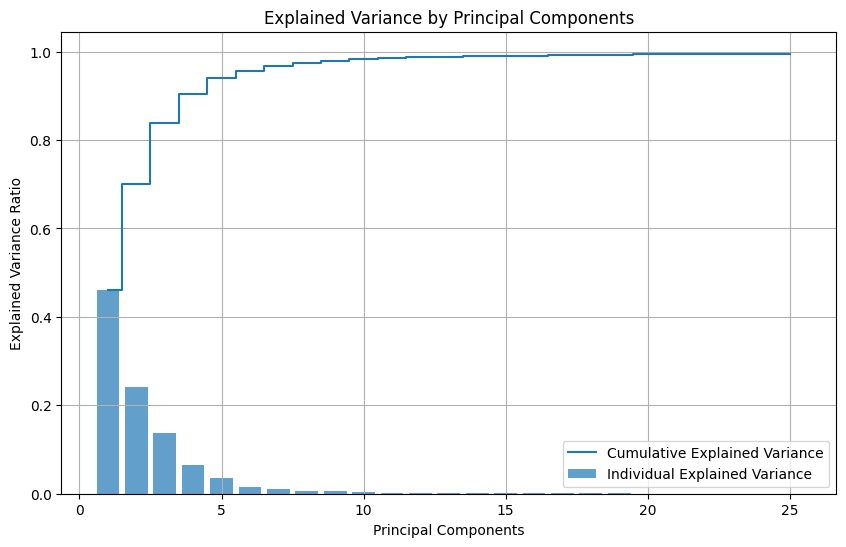

In [24]:
# Variance explained by each component
explained_variance = pca.explained_variance_ratio_

# Plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, 26), explained_variance[:25], alpha=0.7, align='center', label='Individual Explained Variance')
plt.step(range(1, 26), explained_variance[:25].cumsum(), where='mid', label='Cumulative Explained Variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.title('Explained Variance by Principal Components')
plt.legend(loc='best')
plt.grid()
plt.show()


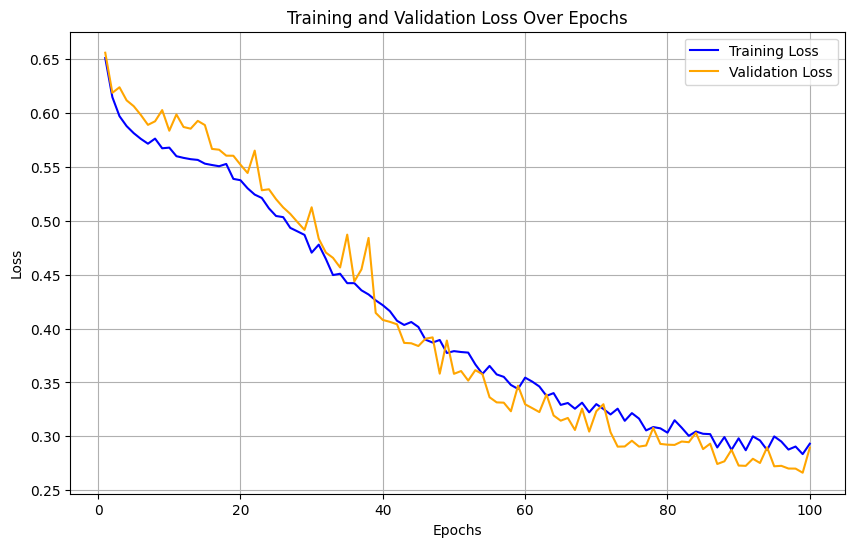

In [27]:
# Plot losses
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), training_losses, label='Training Loss', color='blue')
plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)

# Save the plot to a file
plt.savefig('training_validation_loss.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

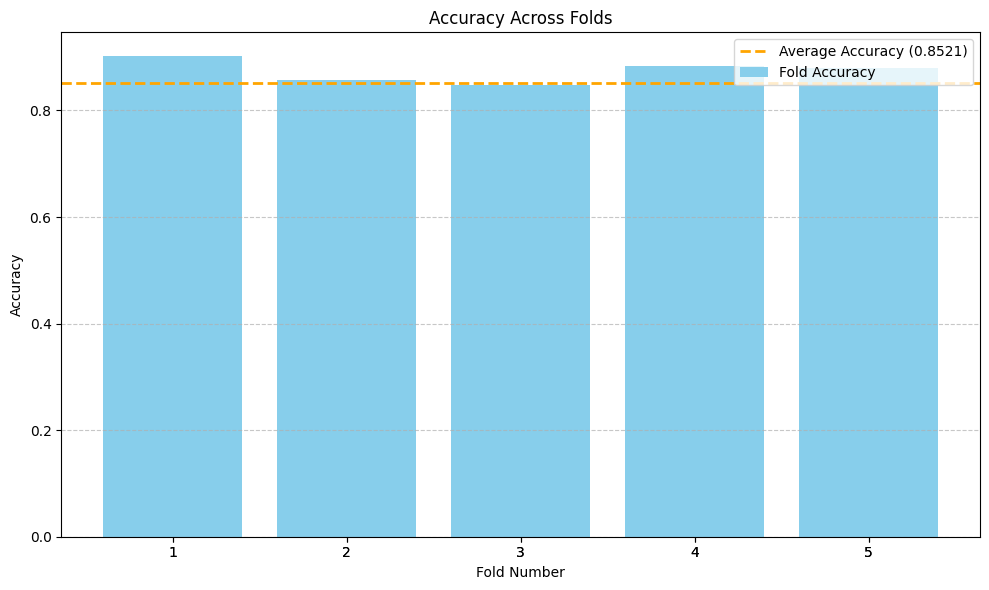

In [28]:
import matplotlib.pyplot as plt

# Example fold metrics
# Replace this with actual fold_metrics from your code

# Extract fold numbers and accuracy values
fold_numbers = [metric["fold"] for metric in fold_metrics]
accuracy_values = [metric["accuracy"] for metric in fold_metrics]
average_accuracy = sum(accuracy_values) / len(accuracy_values)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.bar(fold_numbers, accuracy_values, color="skyblue", label="Fold Accuracy")
plt.axhline(average_accuracy, color="orange", linestyle="--", linewidth=2, label=f"Average Accuracy ({average_accuracy:.4f})")

# Add labels and title
plt.xticks(fold_numbers)
plt.xlabel("Fold Number")
plt.ylabel("Accuracy")
plt.title("Accuracy Across Folds")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()


# FocalLoss

Applying PCA on Text Embeddings...


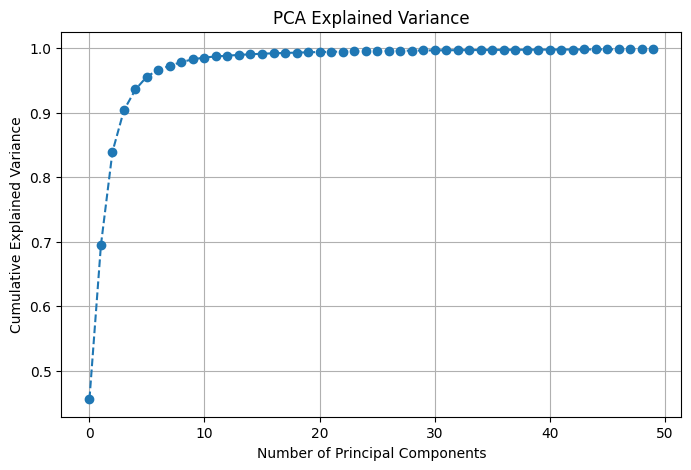


Fold 1/5


Training Progress:  23%|██▎       | 23/100 [00:10<00:33,  2.28epoch/s]


KeyboardInterrupt: 

In [9]:
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from model import CSIModel
import matplotlib.pyplot as plt

# Prepare data
X_text = np.stack(merged_df['text_embeddings'].values)
X_user = merged_df[['friends_count', 'followers_count', 'bi_followers_count']].values
y = (merged_df['label']).astype(int).values  # Convert labels to binary

# Apply PCA to reduce dimensions of text embeddings
print("Applying PCA on Text Embeddings...")
pca = PCA(n_components=50)  # Choose the number of components
X_text_pca = pca.fit_transform(X_text)

# Visualize explained variance ratio
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid()
plt.show()

# Custom Dataset class
class CSIDataset(Dataset):
    def __init__(self, text_data, user_data, labels):
        self.text_data = text_data
        self.user_data = user_data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = torch.tensor(self.text_data[idx], dtype=torch.float32)
        user = torch.tensor(self.user_data[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return text, user, label

class CombinedBCELossWithFocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, focal_weight=0.5):
        """
        Combined Binary Cross-Entropy Loss and Focal Loss
        :param alpha: Weighting factor for focal loss (default 1)
        :param gamma: Focusing parameter for focal loss (default 2)
        :param focal_weight: The weight of focal loss in the combination
        """
        super(CombinedBCELossWithFocalLoss, self).__init__()
        self.bce = nn.BCELoss()  # Binary Cross-Entropy Loss
        self.alpha = alpha
        self.gamma = gamma
        self.focal_weight = focal_weight

    def forward(self, inputs, targets):
        # BCE Loss
        bce_loss = self.bce(inputs, targets)

        # Focal Loss
        pt = torch.sigmoid(inputs)  # Probabilities for Focal Loss
        pt = torch.clamp(pt, 1e-7, 1 - 1e-7)  # Avoid log(0) instability
        focal_loss = self.alpha * (1 - pt) ** self.gamma * targets * torch.log(pt) + \
                     (1 - self.alpha) * pt ** self.gamma * (1 - targets) * torch.log(1 - pt)
        focal_loss = -focal_loss.mean()

        # Combine the two losses
        combined_loss = (1 - self.focal_weight) * bce_loss + self.focal_weight * focal_loss
        return combined_loss

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
text_embedding_dim = X_text_pca.shape[1]  # Updated to the PCA output dimensions
user_feature_dim = X_user.shape[1]
lstm_hidden_dim = 32
fc_hidden_dim = 16
learning_rate = 0.001
num_epochs = 100
k_folds = 5
batch_size = 32

# K-Fold Cross-Validation
kf = KFold(n_splits=k_folds, shuffle=True, random_state=32)

# Loss function
criterion = CombinedBCELossWithFocalLoss(alpha=0.8, gamma=2, focal_weight=0.5)

# Store fold results
fold_results = []
fold_metrics = []
for fold, (train_idx, val_idx) in enumerate(kf.split(X_text_pca)):
    print(f"\nFold {fold + 1}/{k_folds}")

    # Split data into training and validation sets
    train_text = X_text_pca[train_idx]
    train_user = X_user[train_idx]
    train_labels = y[train_idx]

    val_text = X_text_pca[val_idx]
    val_user = X_user[val_idx]
    val_labels = y[val_idx]

    # Create DataLoaders for training and validation sets
    train_dataset = CSIDataset(train_text, train_user, train_labels)
    val_dataset = CSIDataset(val_text, val_user, val_labels)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize the model
    model = CSIModel(text_embedding_dim, user_feature_dim, lstm_hidden_dim, fc_hidden_dim)
    model.to(device)

    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    # Training and Validation
    training_losses = []
    validation_losses = []
    for epoch in tqdm(range(1, num_epochs + 1), desc="Training Progress", unit="epoch"):
        model.train()
        total_train_loss = 0

        for text_batch, user_batch, labels_batch in train_loader:
            text_batch = text_batch.unsqueeze(1)
            text_batch, user_batch, labels_batch = (
                text_batch.to(device),
                user_batch.to(device),
                labels_batch.to(device),
            )

            optimizer.zero_grad()
            outputs = model(text_batch, user_batch).squeeze()
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        training_losses.append(avg_train_loss)

        # Validation
        model.eval()
        total_val_loss = 0
        val_labels_list = []
        val_preds_list = []
        with torch.no_grad():
            for text_batch, user_batch, labels_batch in val_loader:
                text_batch = text_batch.unsqueeze(1)
                text_batch, user_batch, labels_batch = (
                    text_batch.to(device),
                    user_batch.to(device),
                    labels_batch.to(device),
                )
                outputs = model(text_batch, user_batch).squeeze()
                loss = criterion(outputs, labels_batch)
                total_val_loss += loss.item()

                # Collect predictions and labels for metrics
                val_labels_list.extend(labels_batch.cpu().numpy())
                val_preds_list.extend((outputs > 0.5).cpu().numpy())

        avg_val_loss = total_val_loss / len(val_loader)
        validation_losses.append(avg_val_loss)

        # Print every 10 epochs
        if epoch % 100 == 0:
            print(f"Epoch {epoch}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Calculate metrics for the fold
    accuracy = accuracy_score(val_labels_list, val_preds_list)
    precision = precision_score(val_labels_list, val_preds_list)
    recall = recall_score(val_labels_list, val_preds_list)
    f1 = f1_score(val_labels_list, val_preds_list)
    roc_auc = roc_auc_score(val_labels_list, val_preds_list)
    print(f"Fold {fold + 1} Metrics - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, ROC AUC: {roc_auc:.4f}")

    # Store fold metrics
    fold_metrics.append({
        "fold": fold + 1,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc,
    })

# Average results across folds
average_metrics = {
    key: np.mean([fold[key] for fold in fold_metrics])
    for key in fold_metrics[0] if key != "fold"
}
print("\nAverage Metrics Across All Folds")
for metric, value in average_metrics.items():
    print(f"{metric.capitalize()}: {value:.4f}")

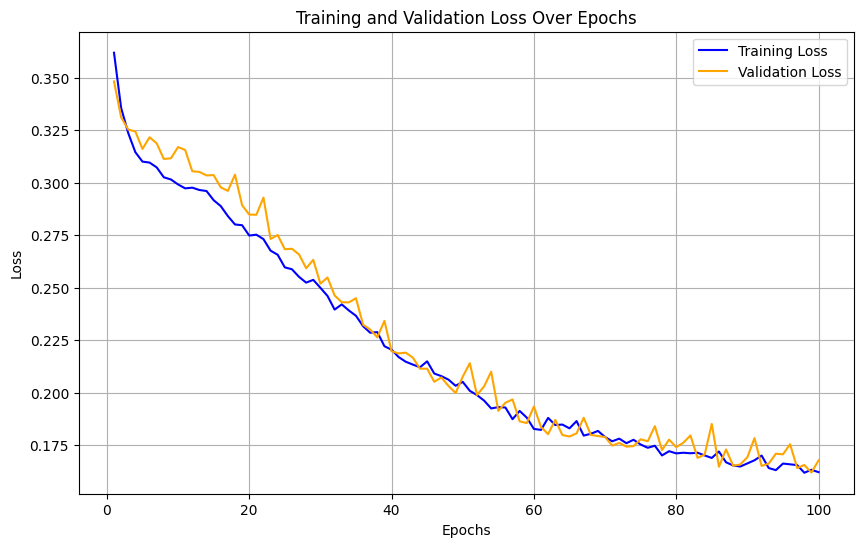

In [21]:
# Plot losses
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), training_losses, label='Training Loss', color='blue')
plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)

# Save the plot to a file
plt.savefig('training_validation_loss.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

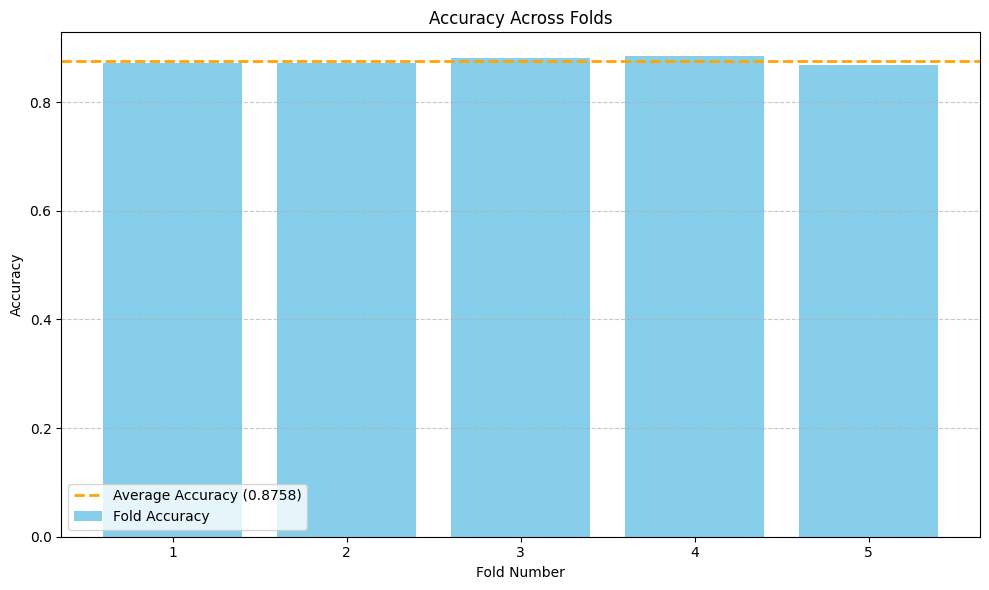

In [22]:
import matplotlib.pyplot as plt

# Example fold metrics
# Replace this with actual fold_metrics from your code

# Extract fold numbers and accuracy values
fold_numbers = [metric["fold"] for metric in fold_metrics]
accuracy_values = [metric["accuracy"] for metric in fold_metrics]
average_accuracy = sum(accuracy_values) / len(accuracy_values)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.bar(fold_numbers, accuracy_values, color="skyblue", label="Fold Accuracy")
plt.axhline(average_accuracy, color="orange", linestyle="--", linewidth=2, label=f"Average Accuracy ({average_accuracy:.4f})")

# Add labels and title
plt.xticks(fold_numbers)
plt.xlabel("Fold Number")
plt.ylabel("Accuracy")
plt.title("Accuracy Across Folds")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()


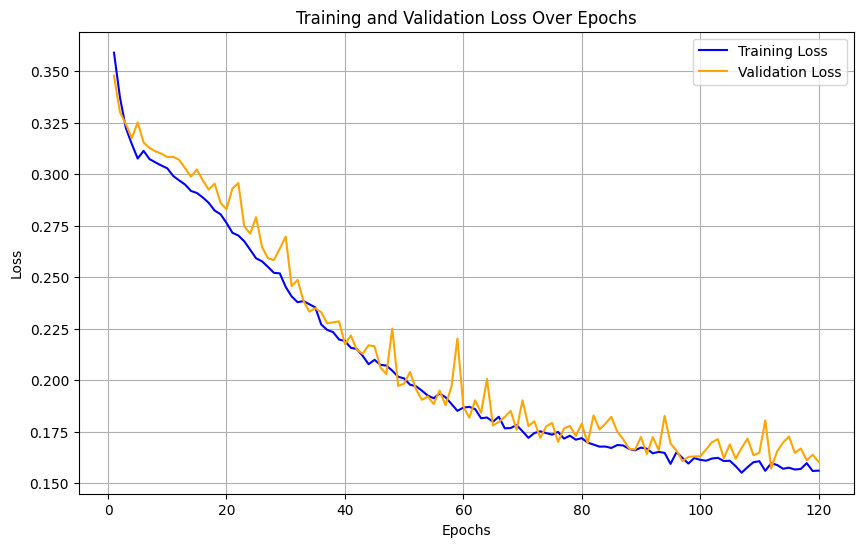

In [29]:
# Plot losses
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), training_losses, label='Training Loss', color='blue')
plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)

# Save the plot to a file
plt.savefig('training_validation_loss.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()